## Important Requirements

In [1]:
from PIL import Image
import math

import matplotlib.pyplot as plt

## Image Steganography

In [2]:
class ImageSteganography:
    @staticmethod
    def text_to_bits(text):
        return ''.join(format(ord(c), '08b') for c in text)

    @staticmethod
    def bits_to_text(bits):
        chars = []
        for i in range(0, len(bits), 8):
            byte = bits[i:i+8]
            chars.append(chr(int(byte, 2)))
        return ''.join(chars)

    def embed_data_with_error(self, cover_image_path, secret_message, output_image_path):
        image = Image.open(cover_image_path)
        pixels = image.load()
        width, height = image.size

        secret_bits = self.text_to_bits(secret_message)
        len_bits = format(len(secret_bits), '032b')
        full_data = len_bits + secret_bits
        data_index = 0

        # Step 1: Global absolute error in red channel
        total_ones, total_zeros = 0, 0
        for y in range(height):
            for x in range(width):
                r, _, _ = pixels[x, y]
                r_bin = format(r, '08b')
                total_ones += r_bin.count('1')
                total_zeros += r_bin.count('0')
        global_error = abs(total_ones - total_zeros) / 2

        changed_pixels = 0

        for y in range(height):
            for x in range(width):
                if data_index >= len(full_data):
                    break

                r, g, b = pixels[x, y]
                r_bin = format(r, '08b')
                ones = r_bin.count('1')
                zeros = r_bin.count('0')
                pixel_error = abs(ones - zeros) / 2

                if pixel_error < global_error:
                    # Hide 2 bits into red channel
                    if data_index + 2 <= len(full_data):
                        bits_to_hide = full_data[data_index:data_index+2]
                        data_index += 2
                    else:
                        bits_to_hide = full_data[data_index:] + '0' * (2 - (len(full_data) - data_index))
                        data_index = len(full_data)

                    r = (r & 0b11111100) | int(bits_to_hide, 2)
                    pixels[x, y] = (r, g, b)
                    changed_pixels += 1

        image.save(output_image_path)
        print(f"Data embedded successfully into: {output_image_path}")
        print(f"Pixels changed using absolute error rule: {changed_pixels}")

    def extract_data(self, stego_image_path):
        image = Image.open(stego_image_path)
        pixels = image.load()
        width, height = image.size

        bits = ''
        for y in range(height):
            for x in range(width):
                r, g, b = pixels[x, y]
                bits += format(r & 0b11, '02b')

        data_len = int(bits[:32], 2)
        secret_bits = bits[32:32 + data_len]
        return self.bits_to_text(secret_bits)

    def calculate_psnr(self, original_image_path, stego_image_path):
        orig = Image.open(original_image_path)
        steg = Image.open(stego_image_path)

        width, height = orig.size
        mse = 0
        for y in range(height):
            for x in range(width):
                r1, g1, b1 = orig.getpixel((x, y))
                r2, g2, b2 = steg.getpixel((x, y))
                mse += ((r1 - r2) ** 2 + (g1 - g2) ** 2 + (b1 - b2) ** 2) / 3

        mse /= (width * height)
        if mse == 0:
            return float('inf')
        psnr = 10 * math.log10(255 ** 2 / mse)
        return psnr

In [3]:
def plot_histogram(image_path, title='Histogram'):
    image = Image.open(image_path)
    red_channel = [pixel[0] for pixel in image.getdata()]

    plt.figure(figsize=(8, 4))
    plt.hist(red_channel, bins=256, range=(0, 255), color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Red Channel Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
def evaluate_accuracy(original_message, extracted_message):
    correct = sum(o == e for o, e in zip(original_message, extracted_message))
    total = len(original_message)
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Total Characters: {total}")
    print(f"Correctly Extracted: {correct}")
    if accuracy < 100:
        print("Mismatch detected in extracted message.")

## Testing

Data embedded successfully into: stego.png
Pixels changed using absolute error rule: 132
Extracted Message: This is a top secret massage.
PSNR: 74.64 dB
Accuracy: 100.00%
Total Characters: 29
Correctly Extracted: 29


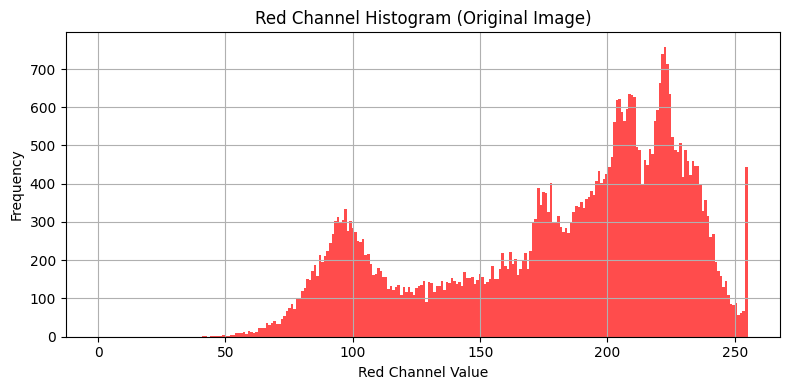

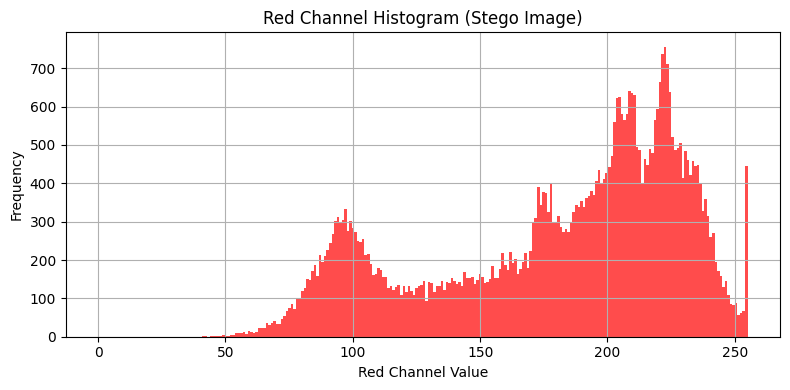

In [5]:
if __name__ == '__main__':
    steg = ImageSteganography()

    cover_image = 'cover.jpg' # @param{type:"string"}
    secret_message = "This is a top secret massage." # @param{type:"string"}
    output_image = 'stego.png' # @param{type:"string"}

    steg.embed_data_with_error(cover_image, secret_message, output_image)
    extracted_message = steg.extract_data(output_image)
    print("Extracted Message:", extracted_message)

    psnr = steg.calculate_psnr(cover_image, output_image)
    print(f"PSNR: {psnr:.2f} dB")


    evaluate_accuracy(secret_message, extracted_message)


    # Plot original image red channel histogram
    plot_histogram(cover_image, title='Red Channel Histogram (Original Image)')


    # Plot stego image red channel histogram
    plot_histogram(output_image, title='Red Channel Histogram (Stego Image)')